Trick for kaggle to work: https://www.kaggle.com/atulanandjha/face-recognition-starter-trick-code-with-output/notebook

Source: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html


In [101]:
from time import time
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os

# libraries to support custom function for copying.

import errno
import shutil

In [102]:
# This part is needed for kaggle notebooks and sklearn.datasets.fetch_lfw_people to work nicely together

def copy(src, dest):
    try:
        shutil.copytree(src, dest)
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)
            
src = '../input/'
dest = '../LFW/lfw_home'
copy(src,dest)
path = '../LFW/'

Directory not copied. Error: [Errno 17] File exists: '../LFW/lfw_home'


In [103]:
# Helper function for plotting

def plot_gallery(images, titles, h, w, n_row=3, n_col=4, total=1):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        if i < total:
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
            plt.title(titles[i], size=12)
            plt.xticks(())
            plt.yticks(())

In [104]:
# Load data
lfw_people = sklearn.datasets.fetch_lfw_people(data_home = path, min_faces_per_person=70,  download_if_missing = False)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# X is the raw images in this case, the number of features being the number of pixels
X = lfw_people.data
n_features = X.shape[1]

# y is the name of the person on the image
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 2914
n_classes: 7


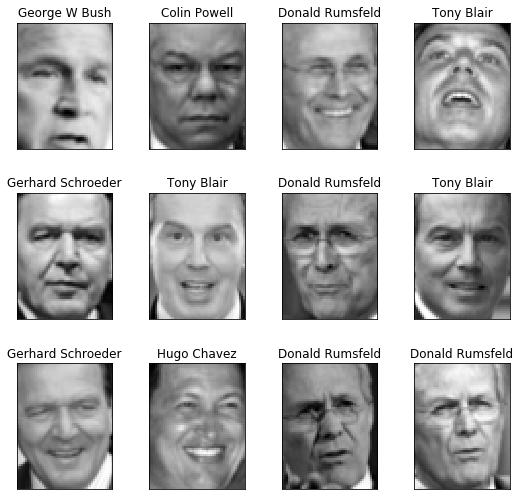

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


titles = target_names[y_train]
plot_gallery(X_train, titles, h, w, total=h*w)

In [107]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 200

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


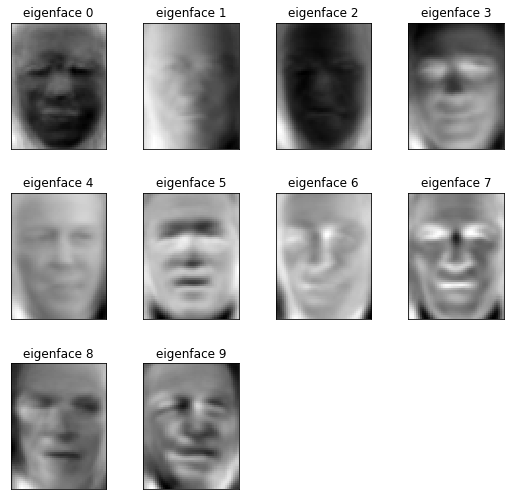

In [108]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, total=n_components)

plt.show()

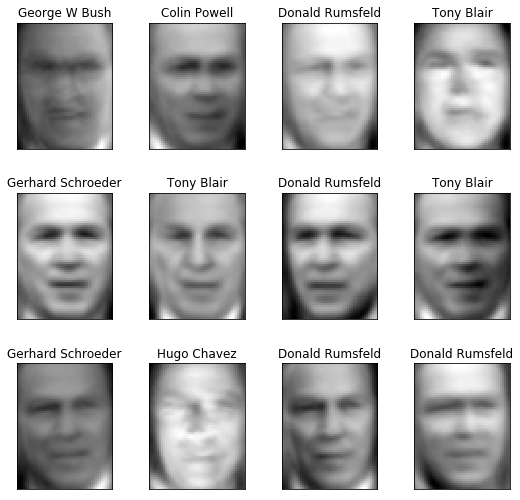

In [109]:
# Reconstructed faces
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_projected = pca.inverse_transform(X_train_pca)

titles = target_names[y_train]
plot_gallery(X_train_projected, titles, h, w, total=h*w)

In [ ]:
# Train a SVM classification model

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
# Quantitative evaluation of the model quality on the test set

y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plt.figure()
plot_gallery(X_test, prediction_titles, h, w, total=h*w)
plt.show()